In [1]:
# Imports
import torch
import torchvision
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.nn.init as init    # For weight initializations
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
from torch.utils.data import (
    DataLoader,
    # Dataset
)  # Gives easier dataset managment and creates mini batches
import torchvision.datasets as datasets  # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
from tqdm import tqdm # For progress bars 
import matplotlib.pyplot as plt # For graphing  
import numpy as np  # For graphing  
import pandas as pd     # For data frames
import seaborn as sns   # For graphing

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 


In [2]:
# Hyperparameters
learning_rate = 1e-3
batch_size = 12000
num_epoches = 5

In [3]:
# Get MNIST data
train_ds = datasets.MNIST(
    root="dataset/", train=True, transform=transforms.ToTensor(), download=True
)
train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)

test_ds = datasets.MNIST(
    root="dataset/", train=False, transform=transforms.ToTensor(), download=True
)
test_loader = DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=False)

In [4]:
class StandardFeedforwardNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(28**2, 392)
        self.Matrix2 = nn.Linear(392, 10)

        init.kaiming_uniform_(self.Matrix1.weight, mode="fan_in", nonlinearity="relu")
        init.kaiming_uniform_(self.Matrix2.weight, mode="fan_in", nonlinearity="relu")        

        self.R = nn.ReLU()

    def forward(self,x):
        x = x.view(-1,28**2)
        x = self.R(self.Matrix1(x))
        x = self.R(self.Matrix2(x))
        return x.squeeze()

In [5]:
# Check parameter matrix sizes
def print_parameter_info(model):
    for name, param in model.named_parameters():
        print(name)
        print(type(param), param.size())

In [6]:
# Train Network
def train_network(device, num_epoches, train_loader, model, criterion, optimizer):
    for epoch in range(num_epoches):
        losses = []

        for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
            # Get data to cuda if possible
            data = data.to(device=device)
            targets = targets.to(device=device)

            # forward
            scores = model(data)
            loss = criterion(scores, targets)

            losses.append(loss.item())
            # backward
            optimizer.zero_grad()
            loss.backward()

            # gradient descent or adam step
            optimizer.step()

        # print(f"Cost at epoch {epoch} is {sum(losses)/len(losses):.5f}")

In [7]:
def check_accuracy(loader, model):
    if loader.dataset.train:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on test data")

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        accuracy = float(num_correct)/float(num_samples)
        print(f"Got {num_correct} / {num_samples} with accuracy {accuracy*100:.2f}%")

    model.train()
    return accuracy

In [8]:
def run_trials(num_trainings):
  # Define model, loss, and optimizer 
  model = StandardFeedforwardNetwork()
  print_parameter_info(model)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  
  acc_dict = {}
  acc_dict[0] = 0

  # Loop for number of trainings
  for training in range(num_trainings):
    # Train network
    train_network(device, num_epoches, train_loader, model, criterion, optimizer)
    acc_dict[training + 1] = check_accuracy(test_loader, model)

    print(f"Row: {training + 1} | {list(acc_dict.values())}")

  # Plot graph of accuracies after the trial
  ypoints = np.array(list(acc_dict.values()))
  plt.xticks(np.arange(0, len(ypoints), 1.0))
  plt.xlabel("Number of trainings")
  plt.ylabel("Accuracy")
  plt.plot(ypoints)
  plt.show()

  return list(acc_dict.values())

--- NEW MODEL 0 --- 
Matrix1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
Matrix1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
Matrix2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 392])
Matrix2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


Checking accuracy on test data
Got 7862 / 10000 with accuracy 78.62%
Row: 1 | [0, 0.7862]


100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Checking accuracy on test data
Got 8148 / 10000 with accuracy 81.48%
Row: 2 | [0, 0.7862, 0.8148]


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Checking accuracy on test data
Got 8284 / 10000 with accuracy 82.84%
Row: 3 | [0, 0.7862, 0.8148, 0.8284]


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Checking accuracy on test data
Got 8355 / 10000 with accuracy 83.55%
Row: 4 | [0, 0.7862, 0.8148, 0.8284, 0.8355]


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Checking accuracy on test data
Got 8410 / 10000 with accuracy 84.10%
Row: 5 | [0, 0.7862, 0.8148, 0.8284, 0.8355, 0.841]


100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


Checking accuracy on test data
Got 8473 / 10000 with accuracy 84.73%
Row: 6 | [0, 0.7862, 0.8148, 0.8284, 0.8355, 0.841, 0.8473]


100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Checking accuracy on test data
Got 8514 / 10000 with accuracy 85.14%
Row: 7 | [0, 0.7862, 0.8148, 0.8284, 0.8355, 0.841, 0.8473, 0.8514]


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Checking accuracy on test data
Got 8543 / 10000 with accuracy 85.43%
Row: 8 | [0, 0.7862, 0.8148, 0.8284, 0.8355, 0.841, 0.8473, 0.8514, 0.8543]


100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


Checking accuracy on test data
Got 8566 / 10000 with accuracy 85.66%
Row: 9 | [0, 0.7862, 0.8148, 0.8284, 0.8355, 0.841, 0.8473, 0.8514, 0.8543, 0.8566]


100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


Checking accuracy on test data
Got 8586 / 10000 with accuracy 85.86%
Row: 10 | [0, 0.7862, 0.8148, 0.8284, 0.8355, 0.841, 0.8473, 0.8514, 0.8543, 0.8566, 0.8586]


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Checking accuracy on test data
Got 8604 / 10000 with accuracy 86.04%
Row: 11 | [0, 0.7862, 0.8148, 0.8284, 0.8355, 0.841, 0.8473, 0.8514, 0.8543, 0.8566, 0.8586, 0.8604]


100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


Checking accuracy on test data
Got 8607 / 10000 with accuracy 86.07%
Row: 12 | [0, 0.7862, 0.8148, 0.8284, 0.8355, 0.841, 0.8473, 0.8514, 0.8543, 0.8566, 0.8586, 0.8604, 0.8607]


100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Checking accuracy on test data
Got 8631 / 10000 with accuracy 86.31%
Row: 13 | [0, 0.7862, 0.8148, 0.8284, 0.8355, 0.841, 0.8473, 0.8514, 0.8543, 0.8566, 0.8586, 0.8604, 0.8607, 0.8631]


100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Checking accuracy on test data
Got 8636 / 10000 with accuracy 86.36%
Row: 14 | [0, 0.7862, 0.8148, 0.8284, 0.8355, 0.841, 0.8473, 0.8514, 0.8543, 0.8566, 0.8586, 0.8604, 0.8607, 0.8631, 0.8636]


100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Checking accuracy on test data
Got 8642 / 10000 with accuracy 86.42%
Row: 15 | [0, 0.7862, 0.8148, 0.8284, 0.8355, 0.841, 0.8473, 0.8514, 0.8543, 0.8566, 0.8586, 0.8604, 0.8607, 0.8631, 0.8636, 0.8642]


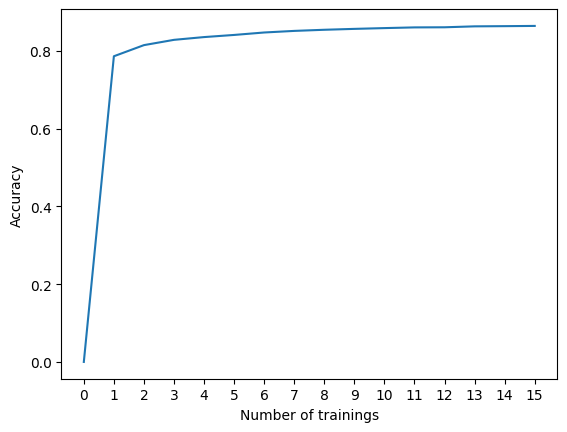

--- NEW MODEL 1 --- 
Matrix1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
Matrix1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
Matrix2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 392])
Matrix2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Checking accuracy on test data
Got 7390 / 10000 with accuracy 73.90%
Row: 1 | [0, 0.739]


100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


Checking accuracy on test data
Got 7536 / 10000 with accuracy 75.36%
Row: 2 | [0, 0.739, 0.7536]


100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


Checking accuracy on test data
Got 7632 / 10000 with accuracy 76.32%
Row: 3 | [0, 0.739, 0.7536, 0.7632]


100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Checking accuracy on test data
Got 7699 / 10000 with accuracy 76.99%
Row: 4 | [0, 0.739, 0.7536, 0.7632, 0.7699]


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Checking accuracy on test data
Got 7731 / 10000 with accuracy 77.31%
Row: 5 | [0, 0.739, 0.7536, 0.7632, 0.7699, 0.7731]


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Checking accuracy on test data
Got 7765 / 10000 with accuracy 77.65%
Row: 6 | [0, 0.739, 0.7536, 0.7632, 0.7699, 0.7731, 0.7765]


100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Checking accuracy on test data
Got 7798 / 10000 with accuracy 77.98%
Row: 7 | [0, 0.739, 0.7536, 0.7632, 0.7699, 0.7731, 0.7765, 0.7798]


100%|██████████| 5/5 [00:15<00:00,  3.17s/it]


Checking accuracy on test data
Got 7823 / 10000 with accuracy 78.23%
Row: 8 | [0, 0.739, 0.7536, 0.7632, 0.7699, 0.7731, 0.7765, 0.7798, 0.7823]


100%|██████████| 5/5 [00:15<00:00,  3.13s/it]


Checking accuracy on test data
Got 7831 / 10000 with accuracy 78.31%
Row: 9 | [0, 0.739, 0.7536, 0.7632, 0.7699, 0.7731, 0.7765, 0.7798, 0.7823, 0.7831]


100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


Checking accuracy on test data
Got 7843 / 10000 with accuracy 78.43%
Row: 10 | [0, 0.739, 0.7536, 0.7632, 0.7699, 0.7731, 0.7765, 0.7798, 0.7823, 0.7831, 0.7843]


100%|██████████| 5/5 [00:15<00:00,  3.13s/it]


Checking accuracy on test data
Got 7858 / 10000 with accuracy 78.58%
Row: 11 | [0, 0.739, 0.7536, 0.7632, 0.7699, 0.7731, 0.7765, 0.7798, 0.7823, 0.7831, 0.7843, 0.7858]


100%|██████████| 5/5 [00:16<00:00,  3.32s/it]


Checking accuracy on test data
Got 7863 / 10000 with accuracy 78.63%
Row: 12 | [0, 0.739, 0.7536, 0.7632, 0.7699, 0.7731, 0.7765, 0.7798, 0.7823, 0.7831, 0.7843, 0.7858, 0.7863]


100%|██████████| 5/5 [00:15<00:00,  3.20s/it]


Checking accuracy on test data
Got 7871 / 10000 with accuracy 78.71%
Row: 13 | [0, 0.739, 0.7536, 0.7632, 0.7699, 0.7731, 0.7765, 0.7798, 0.7823, 0.7831, 0.7843, 0.7858, 0.7863, 0.7871]


100%|██████████| 5/5 [00:15<00:00,  3.17s/it]


Checking accuracy on test data
Got 7876 / 10000 with accuracy 78.76%
Row: 14 | [0, 0.739, 0.7536, 0.7632, 0.7699, 0.7731, 0.7765, 0.7798, 0.7823, 0.7831, 0.7843, 0.7858, 0.7863, 0.7871, 0.7876]


100%|██████████| 5/5 [00:15<00:00,  3.15s/it]


Checking accuracy on test data
Got 7883 / 10000 with accuracy 78.83%
Row: 15 | [0, 0.739, 0.7536, 0.7632, 0.7699, 0.7731, 0.7765, 0.7798, 0.7823, 0.7831, 0.7843, 0.7858, 0.7863, 0.7871, 0.7876, 0.7883]


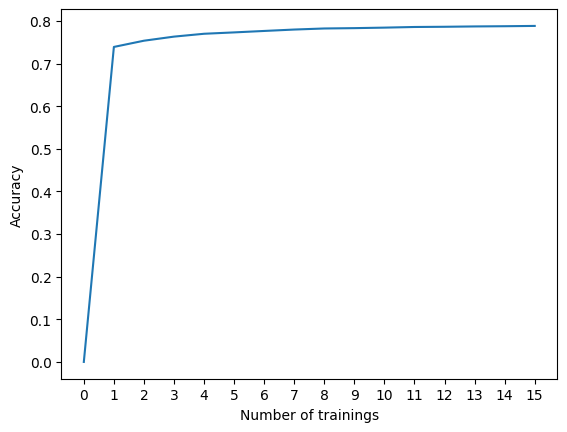

--- NEW MODEL 2 --- 
Matrix1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
Matrix1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
Matrix2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 392])
Matrix2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:16<00:00,  3.25s/it]


Checking accuracy on test data
Got 7088 / 10000 with accuracy 70.88%
Row: 1 | [0, 0.7088]


100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


Checking accuracy on test data
Got 7270 / 10000 with accuracy 72.70%
Row: 2 | [0, 0.7088, 0.727]


100%|██████████| 5/5 [00:15<00:00,  3.20s/it]


Checking accuracy on test data
Got 7402 / 10000 with accuracy 74.02%
Row: 3 | [0, 0.7088, 0.727, 0.7402]


100%|██████████| 5/5 [00:16<00:00,  3.23s/it]


Checking accuracy on test data
Got 7470 / 10000 with accuracy 74.70%
Row: 4 | [0, 0.7088, 0.727, 0.7402, 0.747]


100%|██████████| 5/5 [00:15<00:00,  3.18s/it]


Checking accuracy on test data
Got 7518 / 10000 with accuracy 75.18%
Row: 5 | [0, 0.7088, 0.727, 0.7402, 0.747, 0.7518]


100%|██████████| 5/5 [00:15<00:00,  3.17s/it]


Checking accuracy on test data
Got 7555 / 10000 with accuracy 75.55%
Row: 6 | [0, 0.7088, 0.727, 0.7402, 0.747, 0.7518, 0.7555]


100%|██████████| 5/5 [00:12<00:00,  2.49s/it]


Checking accuracy on test data
Got 7585 / 10000 with accuracy 75.85%
Row: 7 | [0, 0.7088, 0.727, 0.7402, 0.747, 0.7518, 0.7555, 0.7585]


100%|██████████| 5/5 [00:15<00:00,  3.12s/it]


Checking accuracy on test data
Got 7606 / 10000 with accuracy 76.06%
Row: 8 | [0, 0.7088, 0.727, 0.7402, 0.747, 0.7518, 0.7555, 0.7585, 0.7606]


100%|██████████| 5/5 [00:16<00:00,  3.20s/it]


Checking accuracy on test data
Got 7627 / 10000 with accuracy 76.27%
Row: 9 | [0, 0.7088, 0.727, 0.7402, 0.747, 0.7518, 0.7555, 0.7585, 0.7606, 0.7627]


100%|██████████| 5/5 [00:15<00:00,  3.19s/it]


Checking accuracy on test data
Got 7639 / 10000 with accuracy 76.39%
Row: 10 | [0, 0.7088, 0.727, 0.7402, 0.747, 0.7518, 0.7555, 0.7585, 0.7606, 0.7627, 0.7639]


100%|██████████| 5/5 [00:15<00:00,  3.18s/it]


Checking accuracy on test data
Got 7646 / 10000 with accuracy 76.46%
Row: 11 | [0, 0.7088, 0.727, 0.7402, 0.747, 0.7518, 0.7555, 0.7585, 0.7606, 0.7627, 0.7639, 0.7646]


100%|██████████| 5/5 [00:15<00:00,  3.14s/it]


Checking accuracy on test data
Got 7656 / 10000 with accuracy 76.56%
Row: 12 | [0, 0.7088, 0.727, 0.7402, 0.747, 0.7518, 0.7555, 0.7585, 0.7606, 0.7627, 0.7639, 0.7646, 0.7656]


100%|██████████| 5/5 [00:15<00:00,  3.09s/it]


Checking accuracy on test data
Got 7663 / 10000 with accuracy 76.63%
Row: 13 | [0, 0.7088, 0.727, 0.7402, 0.747, 0.7518, 0.7555, 0.7585, 0.7606, 0.7627, 0.7639, 0.7646, 0.7656, 0.7663]


100%|██████████| 5/5 [00:15<00:00,  3.12s/it]


Checking accuracy on test data
Got 7674 / 10000 with accuracy 76.74%
Row: 14 | [0, 0.7088, 0.727, 0.7402, 0.747, 0.7518, 0.7555, 0.7585, 0.7606, 0.7627, 0.7639, 0.7646, 0.7656, 0.7663, 0.7674]


100%|██████████| 5/5 [00:15<00:00,  3.14s/it]


Checking accuracy on test data
Got 7676 / 10000 with accuracy 76.76%
Row: 15 | [0, 0.7088, 0.727, 0.7402, 0.747, 0.7518, 0.7555, 0.7585, 0.7606, 0.7627, 0.7639, 0.7646, 0.7656, 0.7663, 0.7674, 0.7676]


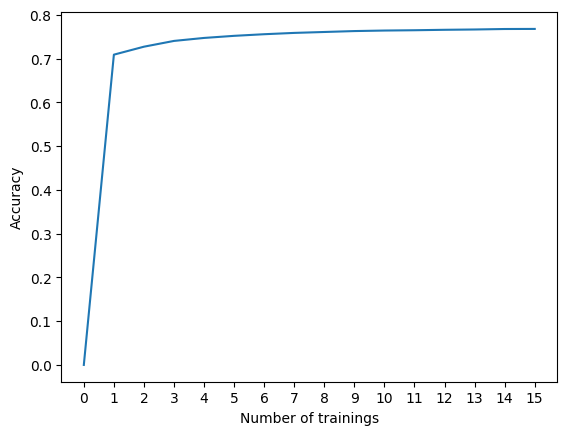

--- NEW MODEL 3 --- 
Matrix1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
Matrix1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
Matrix2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 392])
Matrix2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:15<00:00,  3.09s/it]


Checking accuracy on test data
Got 8057 / 10000 with accuracy 80.57%
Row: 1 | [0, 0.8057]


100%|██████████| 5/5 [00:15<00:00,  3.13s/it]


Checking accuracy on test data
Got 8366 / 10000 with accuracy 83.66%
Row: 2 | [0, 0.8057, 0.8366]


100%|██████████| 5/5 [00:16<00:00,  3.25s/it]


Checking accuracy on test data
Got 8483 / 10000 with accuracy 84.83%
Row: 3 | [0, 0.8057, 0.8366, 0.8483]


100%|██████████| 5/5 [00:15<00:00,  3.18s/it]


Checking accuracy on test data
Got 8570 / 10000 with accuracy 85.70%
Row: 4 | [0, 0.8057, 0.8366, 0.8483, 0.857]


100%|██████████| 5/5 [00:15<00:00,  3.13s/it]


Checking accuracy on test data
Got 8642 / 10000 with accuracy 86.42%
Row: 5 | [0, 0.8057, 0.8366, 0.8483, 0.857, 0.8642]


100%|██████████| 5/5 [00:15<00:00,  3.19s/it]


Checking accuracy on test data
Got 8679 / 10000 with accuracy 86.79%
Row: 6 | [0, 0.8057, 0.8366, 0.8483, 0.857, 0.8642, 0.8679]


100%|██████████| 5/5 [00:15<00:00,  3.14s/it]


Checking accuracy on test data
Got 8720 / 10000 with accuracy 87.20%
Row: 7 | [0, 0.8057, 0.8366, 0.8483, 0.857, 0.8642, 0.8679, 0.872]


100%|██████████| 5/5 [00:15<00:00,  3.17s/it]


Checking accuracy on test data
Got 8756 / 10000 with accuracy 87.56%
Row: 8 | [0, 0.8057, 0.8366, 0.8483, 0.857, 0.8642, 0.8679, 0.872, 0.8756]


100%|██████████| 5/5 [00:15<00:00,  3.15s/it]


Checking accuracy on test data
Got 8776 / 10000 with accuracy 87.76%
Row: 9 | [0, 0.8057, 0.8366, 0.8483, 0.857, 0.8642, 0.8679, 0.872, 0.8756, 0.8776]


100%|██████████| 5/5 [00:16<00:00,  3.24s/it]


Checking accuracy on test data
Got 8789 / 10000 with accuracy 87.89%
Row: 10 | [0, 0.8057, 0.8366, 0.8483, 0.857, 0.8642, 0.8679, 0.872, 0.8756, 0.8776, 0.8789]


100%|██████████| 5/5 [00:15<00:00,  3.08s/it]


Checking accuracy on test data
Got 8805 / 10000 with accuracy 88.05%
Row: 11 | [0, 0.8057, 0.8366, 0.8483, 0.857, 0.8642, 0.8679, 0.872, 0.8756, 0.8776, 0.8789, 0.8805]


100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


Checking accuracy on test data
Got 8807 / 10000 with accuracy 88.07%
Row: 12 | [0, 0.8057, 0.8366, 0.8483, 0.857, 0.8642, 0.8679, 0.872, 0.8756, 0.8776, 0.8789, 0.8805, 0.8807]


100%|██████████| 5/5 [00:15<00:00,  3.17s/it]


Checking accuracy on test data
Got 8815 / 10000 with accuracy 88.15%
Row: 13 | [0, 0.8057, 0.8366, 0.8483, 0.857, 0.8642, 0.8679, 0.872, 0.8756, 0.8776, 0.8789, 0.8805, 0.8807, 0.8815]


100%|██████████| 5/5 [00:15<00:00,  3.13s/it]


Checking accuracy on test data
Got 8832 / 10000 with accuracy 88.32%
Row: 14 | [0, 0.8057, 0.8366, 0.8483, 0.857, 0.8642, 0.8679, 0.872, 0.8756, 0.8776, 0.8789, 0.8805, 0.8807, 0.8815, 0.8832]


100%|██████████| 5/5 [00:15<00:00,  3.08s/it]


Checking accuracy on test data
Got 8835 / 10000 with accuracy 88.35%
Row: 15 | [0, 0.8057, 0.8366, 0.8483, 0.857, 0.8642, 0.8679, 0.872, 0.8756, 0.8776, 0.8789, 0.8805, 0.8807, 0.8815, 0.8832, 0.8835]


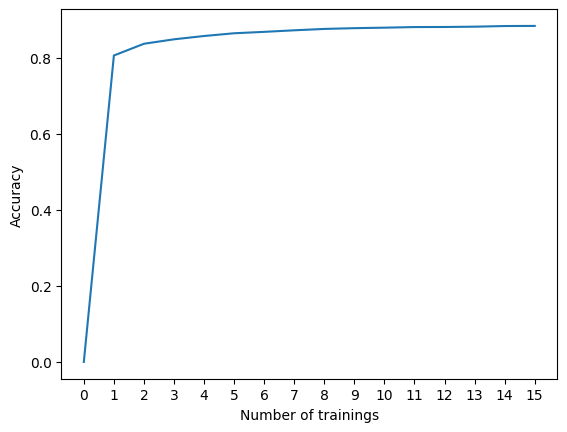

--- NEW MODEL 4 --- 
Matrix1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
Matrix1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
Matrix2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 392])
Matrix2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:15<00:00,  3.15s/it]


Checking accuracy on test data
Got 6309 / 10000 with accuracy 63.09%
Row: 1 | [0, 0.6309]


100%|██████████| 5/5 [00:15<00:00,  3.19s/it]


Checking accuracy on test data
Got 6432 / 10000 with accuracy 64.32%
Row: 2 | [0, 0.6309, 0.6432]


100%|██████████| 5/5 [00:15<00:00,  3.19s/it]


Checking accuracy on test data
Got 6498 / 10000 with accuracy 64.98%
Row: 3 | [0, 0.6309, 0.6432, 0.6498]


100%|██████████| 5/5 [00:15<00:00,  3.14s/it]


Checking accuracy on test data
Got 6538 / 10000 with accuracy 65.38%
Row: 4 | [0, 0.6309, 0.6432, 0.6498, 0.6538]


100%|██████████| 5/5 [00:15<00:00,  3.15s/it]


Checking accuracy on test data
Got 6574 / 10000 with accuracy 65.74%
Row: 5 | [0, 0.6309, 0.6432, 0.6498, 0.6538, 0.6574]


100%|██████████| 5/5 [00:15<00:00,  3.09s/it]


Checking accuracy on test data
Got 6602 / 10000 with accuracy 66.02%
Row: 6 | [0, 0.6309, 0.6432, 0.6498, 0.6538, 0.6574, 0.6602]


100%|██████████| 5/5 [00:15<00:00,  3.14s/it]


Checking accuracy on test data
Got 6624 / 10000 with accuracy 66.24%
Row: 7 | [0, 0.6309, 0.6432, 0.6498, 0.6538, 0.6574, 0.6602, 0.6624]


100%|██████████| 5/5 [00:14<00:00,  2.92s/it]


Checking accuracy on test data
Got 6630 / 10000 with accuracy 66.30%
Row: 8 | [0, 0.6309, 0.6432, 0.6498, 0.6538, 0.6574, 0.6602, 0.6624, 0.663]


100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


Checking accuracy on test data
Got 6645 / 10000 with accuracy 66.45%
Row: 9 | [0, 0.6309, 0.6432, 0.6498, 0.6538, 0.6574, 0.6602, 0.6624, 0.663, 0.6645]


100%|██████████| 5/5 [00:15<00:00,  3.12s/it]


Checking accuracy on test data
Got 6658 / 10000 with accuracy 66.58%
Row: 10 | [0, 0.6309, 0.6432, 0.6498, 0.6538, 0.6574, 0.6602, 0.6624, 0.663, 0.6645, 0.6658]


100%|██████████| 5/5 [00:15<00:00,  3.02s/it]


Checking accuracy on test data
Got 6671 / 10000 with accuracy 66.71%
Row: 11 | [0, 0.6309, 0.6432, 0.6498, 0.6538, 0.6574, 0.6602, 0.6624, 0.663, 0.6645, 0.6658, 0.6671]


100%|██████████| 5/5 [00:15<00:00,  3.19s/it]


Checking accuracy on test data
Got 6678 / 10000 with accuracy 66.78%
Row: 12 | [0, 0.6309, 0.6432, 0.6498, 0.6538, 0.6574, 0.6602, 0.6624, 0.663, 0.6645, 0.6658, 0.6671, 0.6678]


100%|██████████| 5/5 [00:12<00:00,  2.50s/it]


Checking accuracy on test data
Got 6677 / 10000 with accuracy 66.77%
Row: 13 | [0, 0.6309, 0.6432, 0.6498, 0.6538, 0.6574, 0.6602, 0.6624, 0.663, 0.6645, 0.6658, 0.6671, 0.6678, 0.6677]


100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


Checking accuracy on test data
Got 6679 / 10000 with accuracy 66.79%
Row: 14 | [0, 0.6309, 0.6432, 0.6498, 0.6538, 0.6574, 0.6602, 0.6624, 0.663, 0.6645, 0.6658, 0.6671, 0.6678, 0.6677, 0.6679]


100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


Checking accuracy on test data
Got 6683 / 10000 with accuracy 66.83%
Row: 15 | [0, 0.6309, 0.6432, 0.6498, 0.6538, 0.6574, 0.6602, 0.6624, 0.663, 0.6645, 0.6658, 0.6671, 0.6678, 0.6677, 0.6679, 0.6683]


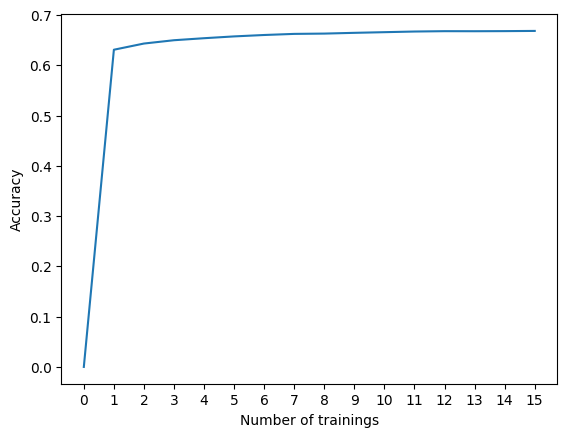

--- NEW MODEL 5 --- 
Matrix1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
Matrix1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
Matrix2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 392])
Matrix2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


Checking accuracy on test data
Got 8901 / 10000 with accuracy 89.01%
Row: 1 | [0, 0.8901]


100%|██████████| 5/5 [00:08<00:00,  1.60s/it]


Checking accuracy on test data
Got 9192 / 10000 with accuracy 91.92%
Row: 2 | [0, 0.8901, 0.9192]


100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


Checking accuracy on test data
Got 9348 / 10000 with accuracy 93.48%
Row: 3 | [0, 0.8901, 0.9192, 0.9348]


100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


Checking accuracy on test data
Got 9441 / 10000 with accuracy 94.41%
Row: 4 | [0, 0.8901, 0.9192, 0.9348, 0.9441]


100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Checking accuracy on test data
Got 9510 / 10000 with accuracy 95.10%
Row: 5 | [0, 0.8901, 0.9192, 0.9348, 0.9441, 0.951]


100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


Checking accuracy on test data
Got 9576 / 10000 with accuracy 95.76%
Row: 6 | [0, 0.8901, 0.9192, 0.9348, 0.9441, 0.951, 0.9576]


100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Checking accuracy on test data
Got 9609 / 10000 with accuracy 96.09%
Row: 7 | [0, 0.8901, 0.9192, 0.9348, 0.9441, 0.951, 0.9576, 0.9609]


100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


Checking accuracy on test data
Got 9635 / 10000 with accuracy 96.35%
Row: 8 | [0, 0.8901, 0.9192, 0.9348, 0.9441, 0.951, 0.9576, 0.9609, 0.9635]


100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


Checking accuracy on test data
Got 9659 / 10000 with accuracy 96.59%
Row: 9 | [0, 0.8901, 0.9192, 0.9348, 0.9441, 0.951, 0.9576, 0.9609, 0.9635, 0.9659]


100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


Checking accuracy on test data
Got 9678 / 10000 with accuracy 96.78%
Row: 10 | [0, 0.8901, 0.9192, 0.9348, 0.9441, 0.951, 0.9576, 0.9609, 0.9635, 0.9659, 0.9678]


100%|██████████| 5/5 [00:07<00:00,  1.60s/it]


Checking accuracy on test data
Got 9693 / 10000 with accuracy 96.93%
Row: 11 | [0, 0.8901, 0.9192, 0.9348, 0.9441, 0.951, 0.9576, 0.9609, 0.9635, 0.9659, 0.9678, 0.9693]


100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


Checking accuracy on test data
Got 9705 / 10000 with accuracy 97.05%
Row: 12 | [0, 0.8901, 0.9192, 0.9348, 0.9441, 0.951, 0.9576, 0.9609, 0.9635, 0.9659, 0.9678, 0.9693, 0.9705]


100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


Checking accuracy on test data
Got 9708 / 10000 with accuracy 97.08%
Row: 13 | [0, 0.8901, 0.9192, 0.9348, 0.9441, 0.951, 0.9576, 0.9609, 0.9635, 0.9659, 0.9678, 0.9693, 0.9705, 0.9708]


100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


Checking accuracy on test data
Got 9730 / 10000 with accuracy 97.30%
Row: 14 | [0, 0.8901, 0.9192, 0.9348, 0.9441, 0.951, 0.9576, 0.9609, 0.9635, 0.9659, 0.9678, 0.9693, 0.9705, 0.9708, 0.973]


100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


Checking accuracy on test data
Got 9736 / 10000 with accuracy 97.36%
Row: 15 | [0, 0.8901, 0.9192, 0.9348, 0.9441, 0.951, 0.9576, 0.9609, 0.9635, 0.9659, 0.9678, 0.9693, 0.9705, 0.9708, 0.973, 0.9736]


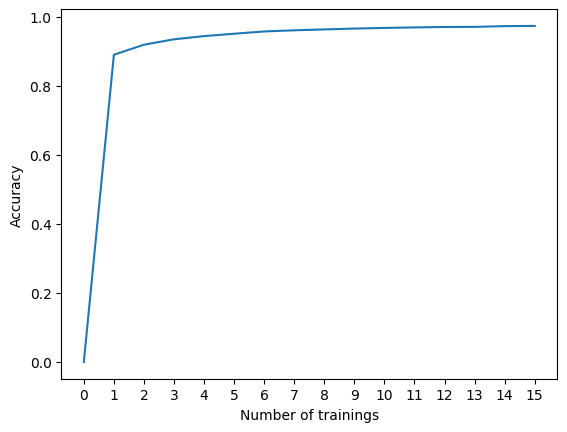

--- NEW MODEL 6 --- 
Matrix1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
Matrix1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
Matrix2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 392])
Matrix2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


Checking accuracy on test data
Got 7476 / 10000 with accuracy 74.76%
Row: 1 | [0, 0.7476]


100%|██████████| 5/5 [00:08<00:00,  1.60s/it]


Checking accuracy on test data
Got 7647 / 10000 with accuracy 76.47%
Row: 2 | [0, 0.7476, 0.7647]


100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


Checking accuracy on test data
Got 7713 / 10000 with accuracy 77.13%
Row: 3 | [0, 0.7476, 0.7647, 0.7713]


100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


Checking accuracy on test data
Got 7785 / 10000 with accuracy 77.85%
Row: 4 | [0, 0.7476, 0.7647, 0.7713, 0.7785]


100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


Checking accuracy on test data
Got 7819 / 10000 with accuracy 78.19%
Row: 5 | [0, 0.7476, 0.7647, 0.7713, 0.7785, 0.7819]


100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


Checking accuracy on test data
Got 7840 / 10000 with accuracy 78.40%
Row: 6 | [0, 0.7476, 0.7647, 0.7713, 0.7785, 0.7819, 0.784]


100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


Checking accuracy on test data
Got 7871 / 10000 with accuracy 78.71%
Row: 7 | [0, 0.7476, 0.7647, 0.7713, 0.7785, 0.7819, 0.784, 0.7871]


100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Checking accuracy on test data
Got 7888 / 10000 with accuracy 78.88%
Row: 8 | [0, 0.7476, 0.7647, 0.7713, 0.7785, 0.7819, 0.784, 0.7871, 0.7888]


100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


Checking accuracy on test data
Got 7908 / 10000 with accuracy 79.08%
Row: 9 | [0, 0.7476, 0.7647, 0.7713, 0.7785, 0.7819, 0.784, 0.7871, 0.7888, 0.7908]


100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


Checking accuracy on test data
Got 7919 / 10000 with accuracy 79.19%
Row: 10 | [0, 0.7476, 0.7647, 0.7713, 0.7785, 0.7819, 0.784, 0.7871, 0.7888, 0.7908, 0.7919]


100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


Checking accuracy on test data
Got 7954 / 10000 with accuracy 79.54%
Row: 11 | [0, 0.7476, 0.7647, 0.7713, 0.7785, 0.7819, 0.784, 0.7871, 0.7888, 0.7908, 0.7919, 0.7954]


100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


Checking accuracy on test data
Got 8736 / 10000 with accuracy 87.36%
Row: 12 | [0, 0.7476, 0.7647, 0.7713, 0.7785, 0.7819, 0.784, 0.7871, 0.7888, 0.7908, 0.7919, 0.7954, 0.8736]


100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


Checking accuracy on test data
Got 8785 / 10000 with accuracy 87.85%
Row: 13 | [0, 0.7476, 0.7647, 0.7713, 0.7785, 0.7819, 0.784, 0.7871, 0.7888, 0.7908, 0.7919, 0.7954, 0.8736, 0.8785]


100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


Checking accuracy on test data
Got 8790 / 10000 with accuracy 87.90%
Row: 14 | [0, 0.7476, 0.7647, 0.7713, 0.7785, 0.7819, 0.784, 0.7871, 0.7888, 0.7908, 0.7919, 0.7954, 0.8736, 0.8785, 0.879]


100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


Checking accuracy on test data
Got 8807 / 10000 with accuracy 88.07%
Row: 15 | [0, 0.7476, 0.7647, 0.7713, 0.7785, 0.7819, 0.784, 0.7871, 0.7888, 0.7908, 0.7919, 0.7954, 0.8736, 0.8785, 0.879, 0.8807]


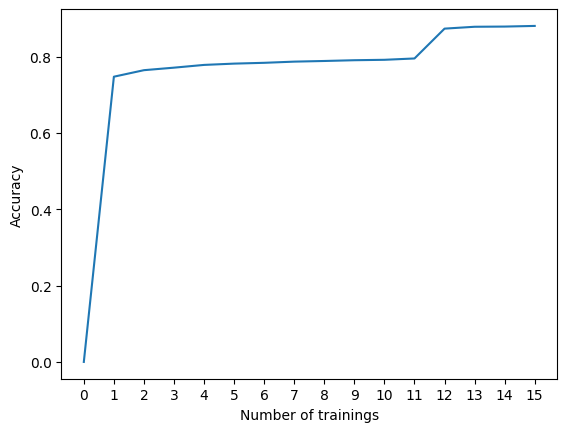

--- NEW MODEL 7 --- 
Matrix1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
Matrix1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
Matrix2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 392])
Matrix2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


Checking accuracy on test data
Got 8345 / 10000 with accuracy 83.45%
Row: 1 | [0, 0.8345]


100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Checking accuracy on test data
Got 8949 / 10000 with accuracy 89.49%
Row: 2 | [0, 0.8345, 0.8949]


100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Checking accuracy on test data
Got 9170 / 10000 with accuracy 91.70%
Row: 3 | [0, 0.8345, 0.8949, 0.917]


100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


Checking accuracy on test data
Got 9293 / 10000 with accuracy 92.93%
Row: 4 | [0, 0.8345, 0.8949, 0.917, 0.9293]


100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


Checking accuracy on test data
Got 9366 / 10000 with accuracy 93.66%
Row: 5 | [0, 0.8345, 0.8949, 0.917, 0.9293, 0.9366]


100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


Checking accuracy on test data
Got 9463 / 10000 with accuracy 94.63%
Row: 6 | [0, 0.8345, 0.8949, 0.917, 0.9293, 0.9366, 0.9463]


100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


Checking accuracy on test data
Got 9512 / 10000 with accuracy 95.12%
Row: 7 | [0, 0.8345, 0.8949, 0.917, 0.9293, 0.9366, 0.9463, 0.9512]


100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


Checking accuracy on test data
Got 9555 / 10000 with accuracy 95.55%
Row: 8 | [0, 0.8345, 0.8949, 0.917, 0.9293, 0.9366, 0.9463, 0.9512, 0.9555]


100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


Checking accuracy on test data
Got 9581 / 10000 with accuracy 95.81%
Row: 9 | [0, 0.8345, 0.8949, 0.917, 0.9293, 0.9366, 0.9463, 0.9512, 0.9555, 0.9581]


100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


Checking accuracy on test data
Got 9612 / 10000 with accuracy 96.12%
Row: 10 | [0, 0.8345, 0.8949, 0.917, 0.9293, 0.9366, 0.9463, 0.9512, 0.9555, 0.9581, 0.9612]


100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


Checking accuracy on test data
Got 9624 / 10000 with accuracy 96.24%
Row: 11 | [0, 0.8345, 0.8949, 0.917, 0.9293, 0.9366, 0.9463, 0.9512, 0.9555, 0.9581, 0.9612, 0.9624]


100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


Checking accuracy on test data
Got 9654 / 10000 with accuracy 96.54%
Row: 12 | [0, 0.8345, 0.8949, 0.917, 0.9293, 0.9366, 0.9463, 0.9512, 0.9555, 0.9581, 0.9612, 0.9624, 0.9654]


100%|██████████| 5/5 [00:07<00:00,  1.60s/it]


Checking accuracy on test data
Got 9666 / 10000 with accuracy 96.66%
Row: 13 | [0, 0.8345, 0.8949, 0.917, 0.9293, 0.9366, 0.9463, 0.9512, 0.9555, 0.9581, 0.9612, 0.9624, 0.9654, 0.9666]


100%|██████████| 5/5 [00:07<00:00,  1.60s/it]


Checking accuracy on test data
Got 9667 / 10000 with accuracy 96.67%
Row: 14 | [0, 0.8345, 0.8949, 0.917, 0.9293, 0.9366, 0.9463, 0.9512, 0.9555, 0.9581, 0.9612, 0.9624, 0.9654, 0.9666, 0.9667]


100%|██████████| 5/5 [00:07<00:00,  1.60s/it]


Checking accuracy on test data
Got 9673 / 10000 with accuracy 96.73%
Row: 15 | [0, 0.8345, 0.8949, 0.917, 0.9293, 0.9366, 0.9463, 0.9512, 0.9555, 0.9581, 0.9612, 0.9624, 0.9654, 0.9666, 0.9667, 0.9673]


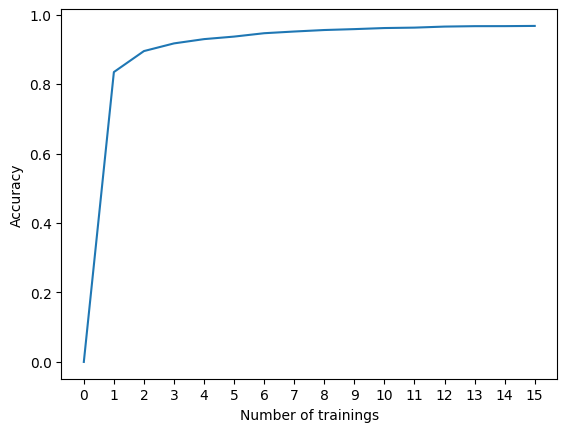

--- NEW MODEL 8 --- 
Matrix1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
Matrix1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
Matrix2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 392])
Matrix2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


Checking accuracy on test data
Got 8032 / 10000 with accuracy 80.32%
Row: 1 | [0, 0.8032]


100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


Checking accuracy on test data
Got 8336 / 10000 with accuracy 83.36%
Row: 2 | [0, 0.8032, 0.8336]


100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


Checking accuracy on test data
Got 8450 / 10000 with accuracy 84.50%
Row: 3 | [0, 0.8032, 0.8336, 0.845]


100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


Checking accuracy on test data
Got 8533 / 10000 with accuracy 85.33%
Row: 4 | [0, 0.8032, 0.8336, 0.845, 0.8533]


100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


Checking accuracy on test data
Got 8600 / 10000 with accuracy 86.00%
Row: 5 | [0, 0.8032, 0.8336, 0.845, 0.8533, 0.86]


100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


Checking accuracy on test data
Got 8641 / 10000 with accuracy 86.41%
Row: 6 | [0, 0.8032, 0.8336, 0.845, 0.8533, 0.86, 0.8641]


100%|██████████| 5/5 [00:08<00:00,  1.60s/it]


Checking accuracy on test data
Got 8667 / 10000 with accuracy 86.67%
Row: 7 | [0, 0.8032, 0.8336, 0.845, 0.8533, 0.86, 0.8641, 0.8667]


100%|██████████| 5/5 [00:08<00:00,  1.60s/it]


Checking accuracy on test data
Got 8685 / 10000 with accuracy 86.85%
Row: 8 | [0, 0.8032, 0.8336, 0.845, 0.8533, 0.86, 0.8641, 0.8667, 0.8685]


100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


Checking accuracy on test data
Got 8709 / 10000 with accuracy 87.09%
Row: 9 | [0, 0.8032, 0.8336, 0.845, 0.8533, 0.86, 0.8641, 0.8667, 0.8685, 0.8709]


100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


Checking accuracy on test data
Got 8721 / 10000 with accuracy 87.21%
Row: 10 | [0, 0.8032, 0.8336, 0.845, 0.8533, 0.86, 0.8641, 0.8667, 0.8685, 0.8709, 0.8721]


100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


Checking accuracy on test data
Got 8735 / 10000 with accuracy 87.35%
Row: 11 | [0, 0.8032, 0.8336, 0.845, 0.8533, 0.86, 0.8641, 0.8667, 0.8685, 0.8709, 0.8721, 0.8735]


100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


Checking accuracy on test data
Got 8746 / 10000 with accuracy 87.46%
Row: 12 | [0, 0.8032, 0.8336, 0.845, 0.8533, 0.86, 0.8641, 0.8667, 0.8685, 0.8709, 0.8721, 0.8735, 0.8746]


100%|██████████| 5/5 [00:08<00:00,  1.60s/it]


Checking accuracy on test data
Got 8763 / 10000 with accuracy 87.63%
Row: 13 | [0, 0.8032, 0.8336, 0.845, 0.8533, 0.86, 0.8641, 0.8667, 0.8685, 0.8709, 0.8721, 0.8735, 0.8746, 0.8763]


100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


Checking accuracy on test data
Got 8772 / 10000 with accuracy 87.72%
Row: 14 | [0, 0.8032, 0.8336, 0.845, 0.8533, 0.86, 0.8641, 0.8667, 0.8685, 0.8709, 0.8721, 0.8735, 0.8746, 0.8763, 0.8772]


100%|██████████| 5/5 [00:08<00:00,  1.60s/it]


Checking accuracy on test data
Got 8782 / 10000 with accuracy 87.82%
Row: 15 | [0, 0.8032, 0.8336, 0.845, 0.8533, 0.86, 0.8641, 0.8667, 0.8685, 0.8709, 0.8721, 0.8735, 0.8746, 0.8763, 0.8772, 0.8782]


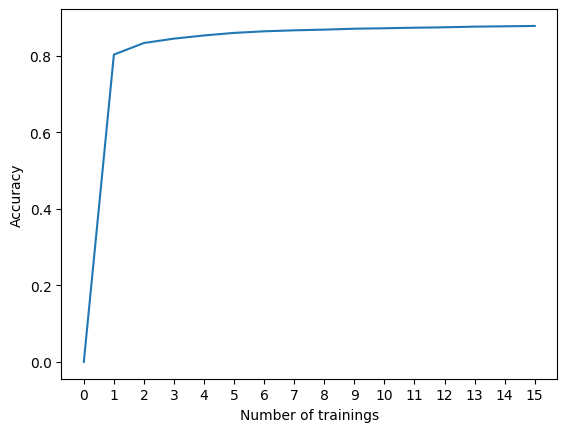

--- NEW MODEL 9 --- 
Matrix1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
Matrix1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
Matrix2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 392])
Matrix2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


Checking accuracy on test data
Got 7333 / 10000 with accuracy 73.33%
Row: 1 | [0, 0.7333]


100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


Checking accuracy on test data
Got 7519 / 10000 with accuracy 75.19%
Row: 2 | [0, 0.7333, 0.7519]


100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


Checking accuracy on test data
Got 7606 / 10000 with accuracy 76.06%
Row: 3 | [0, 0.7333, 0.7519, 0.7606]


100%|██████████| 5/5 [00:08<00:00,  1.60s/it]


Checking accuracy on test data
Got 7657 / 10000 with accuracy 76.57%
Row: 4 | [0, 0.7333, 0.7519, 0.7606, 0.7657]


100%|██████████| 5/5 [00:07<00:00,  1.60s/it]


Checking accuracy on test data
Got 7693 / 10000 with accuracy 76.93%
Row: 5 | [0, 0.7333, 0.7519, 0.7606, 0.7657, 0.7693]


100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


Checking accuracy on test data
Got 7728 / 10000 with accuracy 77.28%
Row: 6 | [0, 0.7333, 0.7519, 0.7606, 0.7657, 0.7693, 0.7728]


100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


Checking accuracy on test data
Got 7758 / 10000 with accuracy 77.58%
Row: 7 | [0, 0.7333, 0.7519, 0.7606, 0.7657, 0.7693, 0.7728, 0.7758]


100%|██████████| 5/5 [00:07<00:00,  1.60s/it]


Checking accuracy on test data
Got 7776 / 10000 with accuracy 77.76%
Row: 8 | [0, 0.7333, 0.7519, 0.7606, 0.7657, 0.7693, 0.7728, 0.7758, 0.7776]


100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


Checking accuracy on test data
Got 7796 / 10000 with accuracy 77.96%
Row: 9 | [0, 0.7333, 0.7519, 0.7606, 0.7657, 0.7693, 0.7728, 0.7758, 0.7776, 0.7796]


100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


Checking accuracy on test data
Got 7805 / 10000 with accuracy 78.05%
Row: 10 | [0, 0.7333, 0.7519, 0.7606, 0.7657, 0.7693, 0.7728, 0.7758, 0.7776, 0.7796, 0.7805]


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Checking accuracy on test data
Got 7815 / 10000 with accuracy 78.15%
Row: 11 | [0, 0.7333, 0.7519, 0.7606, 0.7657, 0.7693, 0.7728, 0.7758, 0.7776, 0.7796, 0.7805, 0.7815]


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Checking accuracy on test data
Got 7828 / 10000 with accuracy 78.28%
Row: 12 | [0, 0.7333, 0.7519, 0.7606, 0.7657, 0.7693, 0.7728, 0.7758, 0.7776, 0.7796, 0.7805, 0.7815, 0.7828]


100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Checking accuracy on test data
Got 7835 / 10000 with accuracy 78.35%
Row: 13 | [0, 0.7333, 0.7519, 0.7606, 0.7657, 0.7693, 0.7728, 0.7758, 0.7776, 0.7796, 0.7805, 0.7815, 0.7828, 0.7835]


100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Checking accuracy on test data
Got 7843 / 10000 with accuracy 78.43%
Row: 14 | [0, 0.7333, 0.7519, 0.7606, 0.7657, 0.7693, 0.7728, 0.7758, 0.7776, 0.7796, 0.7805, 0.7815, 0.7828, 0.7835, 0.7843]


100%|██████████| 5/5 [00:09<00:00,  1.81s/it]


Checking accuracy on test data
Got 7842 / 10000 with accuracy 78.42%
Row: 15 | [0, 0.7333, 0.7519, 0.7606, 0.7657, 0.7693, 0.7728, 0.7758, 0.7776, 0.7796, 0.7805, 0.7815, 0.7828, 0.7835, 0.7843, 0.7842]


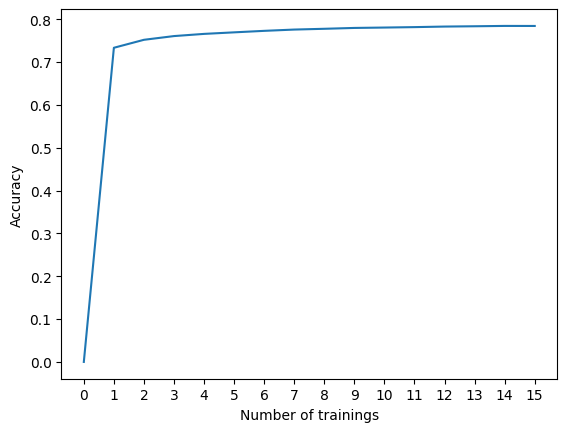

Test 0: [0, 0.7862, 0.8148, 0.8284, 0.8355, 0.841, 0.8473, 0.8514, 0.8543, 0.8566, 0.8586, 0.8604, 0.8607, 0.8631, 0.8636, 0.8642]
Test 1: [0, 0.739, 0.7536, 0.7632, 0.7699, 0.7731, 0.7765, 0.7798, 0.7823, 0.7831, 0.7843, 0.7858, 0.7863, 0.7871, 0.7876, 0.7883]
Test 2: [0, 0.7088, 0.727, 0.7402, 0.747, 0.7518, 0.7555, 0.7585, 0.7606, 0.7627, 0.7639, 0.7646, 0.7656, 0.7663, 0.7674, 0.7676]
Test 3: [0, 0.8057, 0.8366, 0.8483, 0.857, 0.8642, 0.8679, 0.872, 0.8756, 0.8776, 0.8789, 0.8805, 0.8807, 0.8815, 0.8832, 0.8835]
Test 4: [0, 0.6309, 0.6432, 0.6498, 0.6538, 0.6574, 0.6602, 0.6624, 0.663, 0.6645, 0.6658, 0.6671, 0.6678, 0.6677, 0.6679, 0.6683]
Test 5: [0, 0.8901, 0.9192, 0.9348, 0.9441, 0.951, 0.9576, 0.9609, 0.9635, 0.9659, 0.9678, 0.9693, 0.9705, 0.9708, 0.973, 0.9736]
Test 6: [0, 0.7476, 0.7647, 0.7713, 0.7785, 0.7819, 0.784, 0.7871, 0.7888, 0.7908, 0.7919, 0.7954, 0.8736, 0.8785, 0.879, 0.8807]
Test 7: [0, 0.8345, 0.8949, 0.917, 0.9293, 0.9366, 0.9463, 0.9512, 0.9555, 0.9581, 0.96

In [9]:
num_trainings = 15
num_trials = 10

acc_dict = {}
acc_dict[0] = 0

data = {}

# Loop through number of trials
for trial in range(num_trials):
  print(f"--- NEW MODEL {trial} --- ")
  data[trial] = run_trials(num_trainings)

# Print data after all runs
for i in range(num_trials):
  print(f"Test {i}: {data[i]}")


         0       1       2       3       4       5       6       7       8  \
0   0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1   0.7862  0.7390  0.7088  0.8057  0.6309  0.8901  0.7476  0.8345  0.8032   
2   0.8148  0.7536  0.7270  0.8366  0.6432  0.9192  0.7647  0.8949  0.8336   
3   0.8284  0.7632  0.7402  0.8483  0.6498  0.9348  0.7713  0.9170  0.8450   
4   0.8355  0.7699  0.7470  0.8570  0.6538  0.9441  0.7785  0.9293  0.8533   
5   0.8410  0.7731  0.7518  0.8642  0.6574  0.9510  0.7819  0.9366  0.8600   
6   0.8473  0.7765  0.7555  0.8679  0.6602  0.9576  0.7840  0.9463  0.8641   
7   0.8514  0.7798  0.7585  0.8720  0.6624  0.9609  0.7871  0.9512  0.8667   
8   0.8543  0.7823  0.7606  0.8756  0.6630  0.9635  0.7888  0.9555  0.8685   
9   0.8566  0.7831  0.7627  0.8776  0.6645  0.9659  0.7908  0.9581  0.8709   
10  0.8586  0.7843  0.7639  0.8789  0.6658  0.9678  0.7919  0.9612  0.8721   
11  0.8604  0.7858  0.7646  0.8805  0.6671  0.9693  0.7954  0.96

<ErrorbarContainer object of 3 artists>

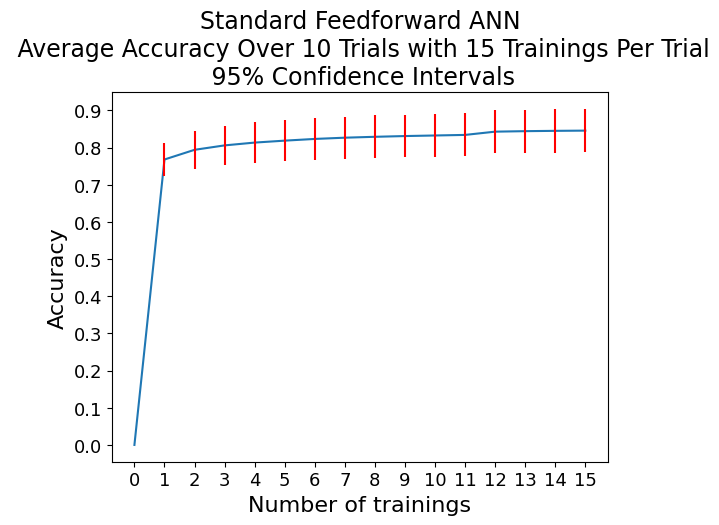

In [16]:
# Convert list of data over tests into a data frame
df = pd.DataFrame(data)
print(df)

x_values = list(range(len(df)))
trial_idx_list = list(range(num_trials))

ci_values = []

# Calculate the mean accuracy for each training per trial
mean_values = df[trial_idx_list].mean(axis=1).tolist()

# Calculate confidence intervals for each training
for _, row in df[trial_idx_list].iterrows():
  mean = row.mean()
  sem = row.sem()
  ci = sem * 1.96  # 95% confidence interval
  ci_values.append(ci)

plt.title(f"Standard Feedforward ANN\n Average Accuracy Over {num_trials} Trials with {num_trainings} Trainings Per Trial\n 95% Confidence Intervals", fontsize = 17)
plt.xlabel("Number of trainings", fontsize = 16)
plt.ylabel("Accuracy", fontsize = 16)
plt.xticks(np.arange(0, num_trainings + 1, 1), fontsize = 13)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize = 13)

sns.lineplot(x = x_values, y = mean_values)
plt.errorbar(x = x_values, y = mean_values, yerr=ci_values, linestyle='None', color='red')